## Draw precipitation figures based on hourly and 4-km track data


In [1]:
%load_ext autoreload
%autoreload 2
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from track_util import track_util
%config InlineBackend.figure_format='retina'

In [2]:
# Parameters
projectdir = '/rcfs/projects/windpower_wfip2uq/liuy351/Tracer'
track_extent = [-97,-93,28,32]
map_extent = [-100,-90,25,35]
pcptype  = ["Total", "MCS", "IDC", "TC", "NC"]
pcpvname =["totpcp", "mcspcp", "idcpcp", "tcpcp", "ncpcp" ]
intensityvname = ["totintensity", "mcsintensity", "idcintensity", "tcintensity", "ncintensity"]

figdir = './track_fig'
os.makedirs(figdir, exist_ok=True)

# Controlling variables
flag_mkdata=True
year1 = 2005
year2 = 2017

In [3]:
def read_pcp_data(season):
    ds = xr.open_dataset(f"track_data/precp_statistics_{season}.nc")
    coords = xr.open_dataset("../MCS_IDC_database/mcstracking_linkpf/20040101_20041231/mcstrack_20040310_0100.nc")
    ds.coords["lat"] = coords["lat"].data
    ds.coords["lon"] = coords["lon"].data
    rr = map_extent
    ds = ds.sel(lon=slice(*rr[:2]), lat=slice(*rr[2:]))

    return ds

data_MAM = read_pcp_data('MAM')
data_JJA = read_pcp_data('JJA')
data_SON = read_pcp_data('SON')
data_DJF = read_pcp_data('DJF')
lon, lat = data_MAM['lon'].data, data_MAM['lat'].data
data = dict(MAM=data_MAM,
            JJA=data_JJA,
            SON=data_SON,
            DJF=data_DJF,
           )

## Calculate Statistics

In [4]:
from yllib import myfunc
def display_statistics(data, season):
    aave = [myfunc.wgt_area_ave(data[season][v], dim=["lat", "lon"]) for v in pcpvname]
    aave = xr.concat(aave, dim="pcptype").assign_coords({"pcptype": pcpvname})
    # print("Mean precp")
    # print(aave.to_pandas())
    stat_mean = aave

    # print("Contribute to total mean")
    aave = aave / aave[0]
    aave = aave.fillna(0)
    # print(aave.to_pandas())
    stat_contribution = aave
    return stat_mean, stat_contribution
    
stats = [display_statistics(data, season) for season in ['MAM', 'JJA', 'SON', 'DJF']]
# mean (mmh^{-1})
stat_mean = xr.concat([stats[i][0] for i in np.arange(4)], dim='season')
print("mean precipitation  ($mmh^{-1}$)")
print(stat_mean.to_pandas())
# Contribute to total mean (%)
print("Contribute to total mean (%)")
stat_contribution = xr.concat([stats[i][1] for i in np.arange(4)], dim='season')
print(stat_contribution.to_pandas()*100)

mean precipitation  ($mmh^{-1}$)
pcptype    totpcp    mcspcp    idcpcp     tcpcp     ncpcp
season                                                   
0        2.520334  1.638589  0.363883  0.000000  0.517862
1        2.633877  0.943121  0.846585  0.191880  0.652290
2        2.421857  0.914206  0.523884  0.141145  0.842623
3        1.895548  0.905962  0.310421  0.000000  0.679166
Contribute to total mean (%)
pcptype  totpcp     mcspcp     idcpcp     tcpcp      ncpcp
season                                                    
0         100.0  65.014748  14.437902  0.000000  20.547337
1         100.0  35.807331  32.142174  7.285089  24.765390
2         100.0  37.748150  21.631477  5.827956  34.792416
3         100.0  47.794193  16.376301  0.000000  35.829510


## Draw mean precipitation for each precpitation type and for each season

In [5]:
from yllib.plot import plot_map
import cartopy.crs as ccrs

def plot_on_map(x, y, data, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  

    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    plot_map.set_map(
        ax,
        extent=[np.min(x),np.max(x),np.min(y), np.max(y)],
        gridlines_kw=dict(
            xticks=[-98,-96,-94,-92],
            yticks=[26,28,30,32,34],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[-98,-94] if kwargs.get('drawxlabels', False) else [],
            yticks=[26,30,34] if kwargs.get('drawylabels', False) else [],
        ),
        boundary_kw=dict(
            coastline_kw=dict(linewidth=1.2, alpha=0.8, color='k'),
        ),
    )
    plot_map.add_rectangle(ax, track_extent, zorder=10)


    cmap = kwargs.get('cmap', "WhiteBlueGreenYellowRed")
    clev = kwargs.get('clev', np.arange(0, 40, 1))
    cs, clev = plot_map.add_contourf(
        ax, x, y, data,
        cmap=cmap,clev=clev,
    )
    if kwargs.get('draw_colorbar'):
        plot_map.add_colorbar(cs, ax, clev[::10])
        
    return cs, clev


### Mean precipitation

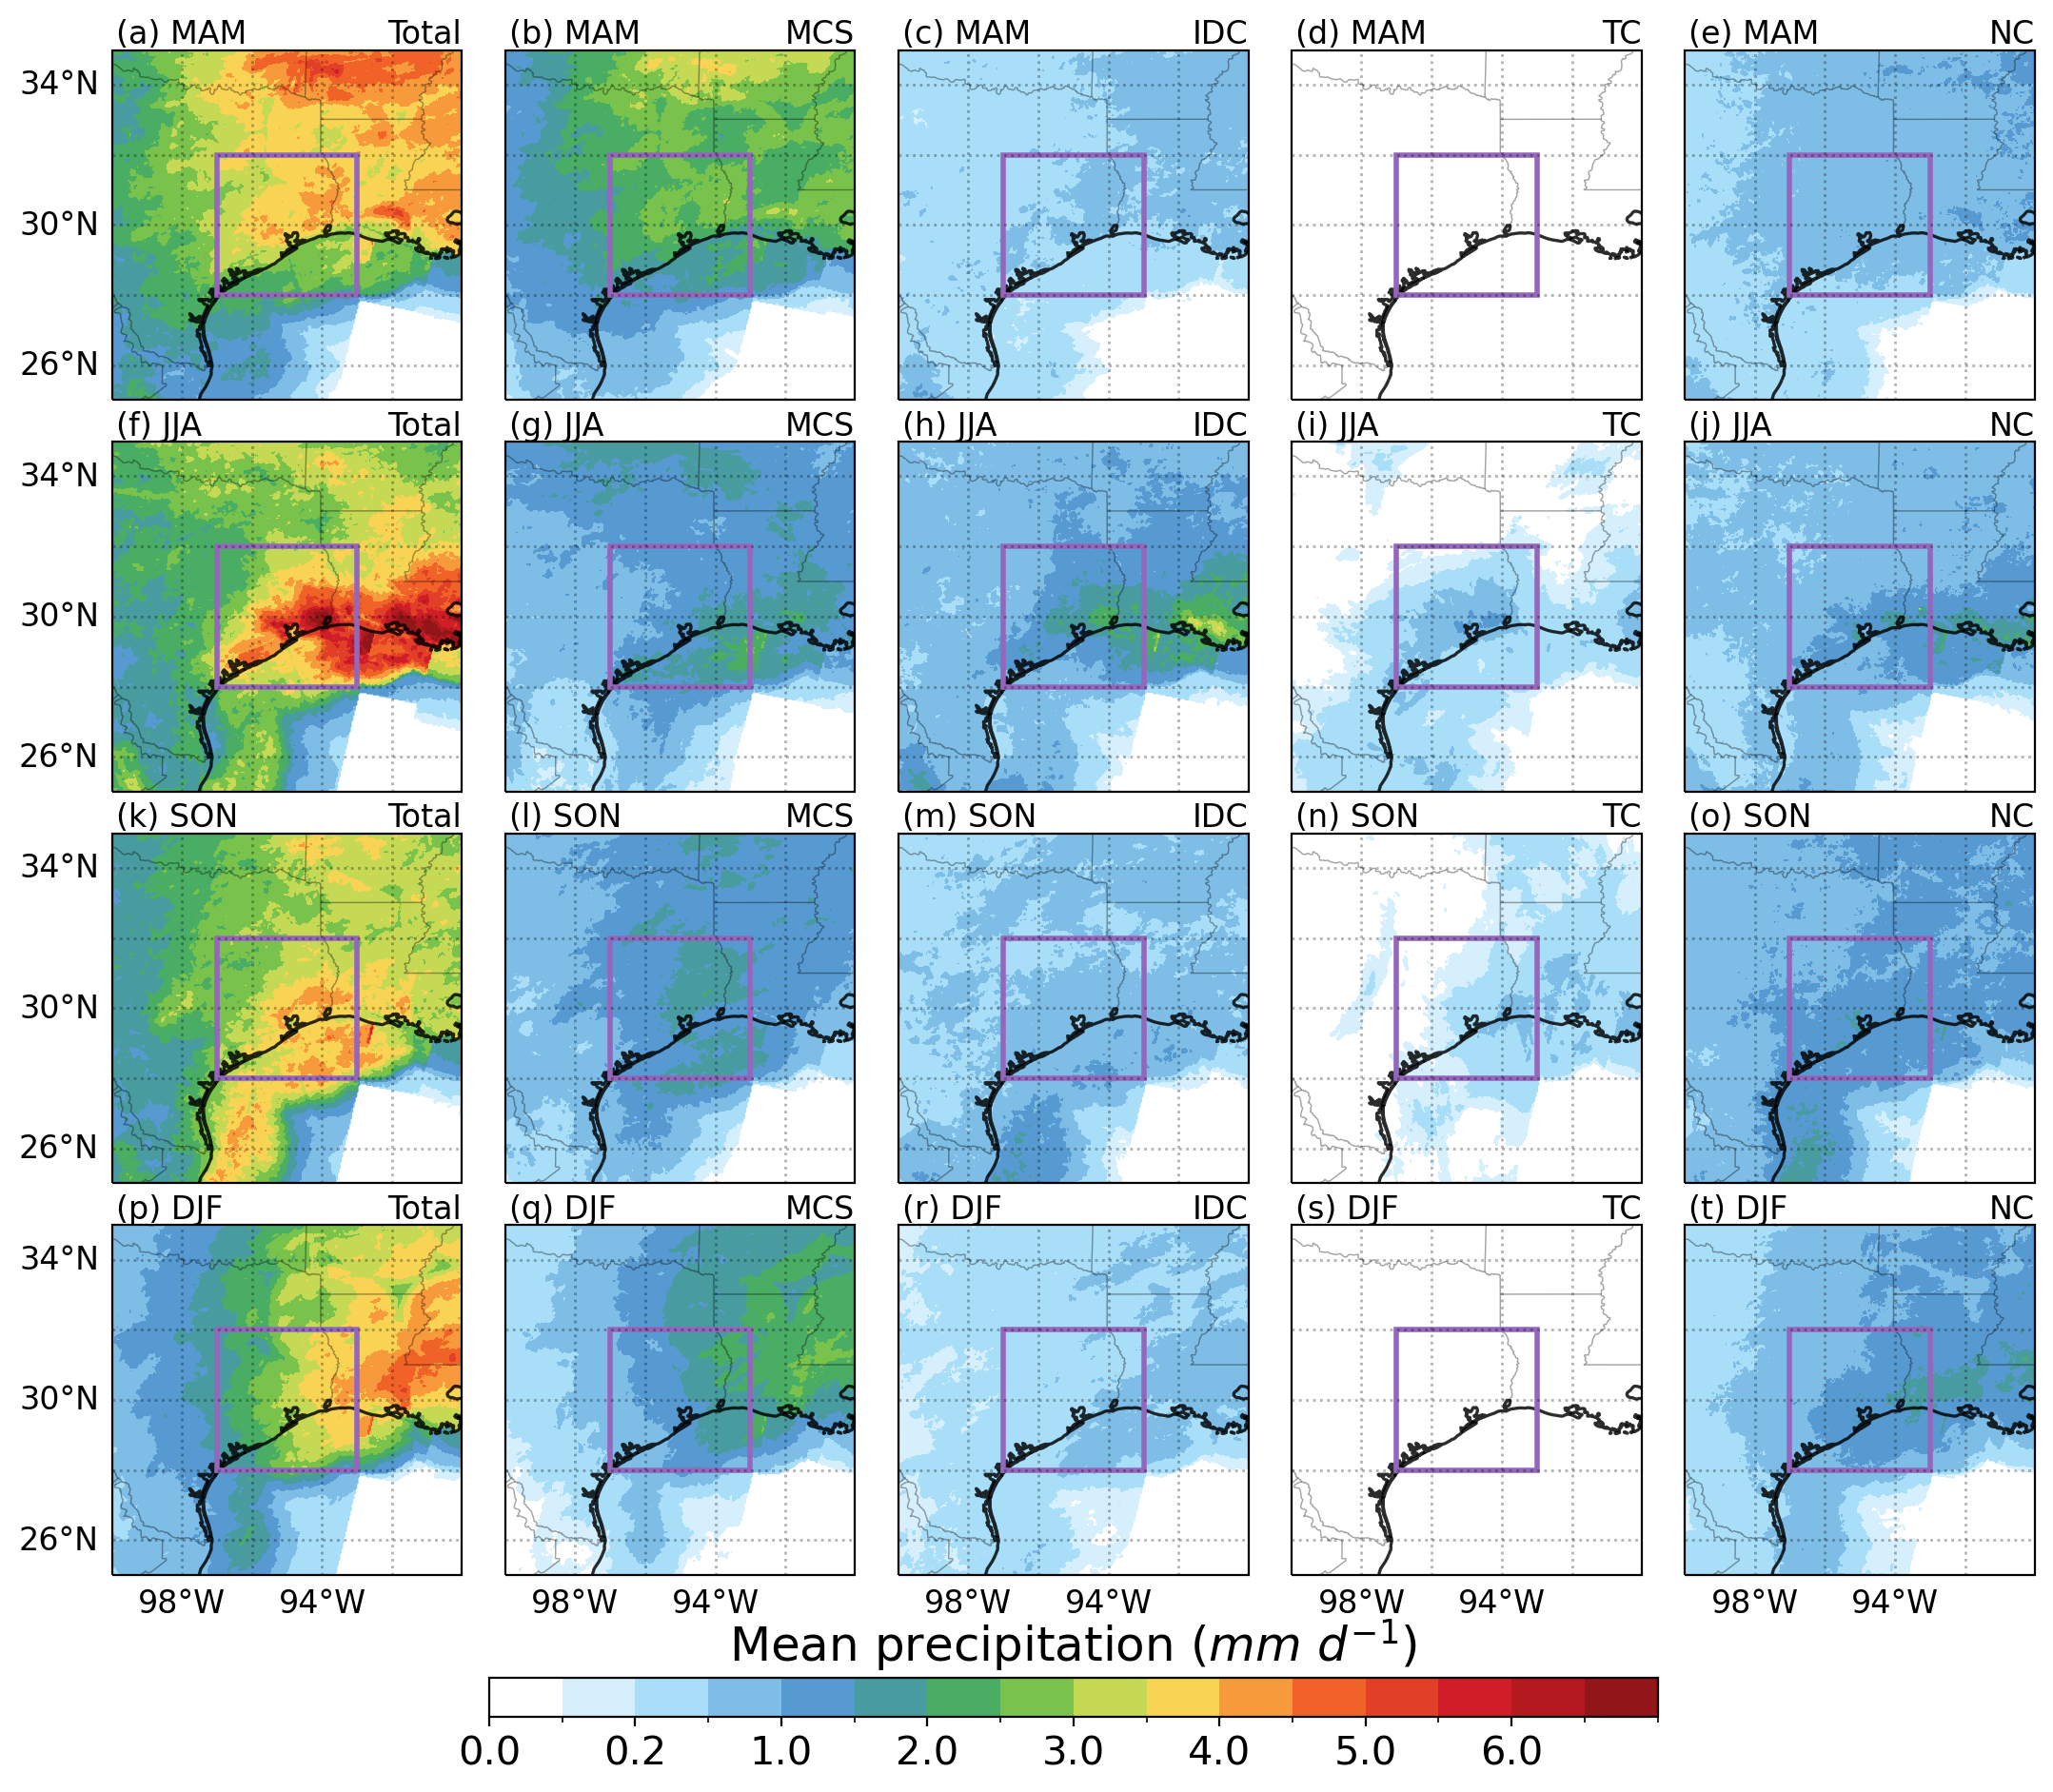

In [9]:
fig, axs = plt.subplots(
    4, 5, figsize=(11, 10), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnopqrst')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
clev = [0, 0.1, 0.2] + list(np.arange(0.5, 7, 0.5))+[1000]
for i, season in enumerate(['MAM', 'JJA', 'SON', 'DJF']):
    _data = data[season]
    for j, v in enumerate(pcpvname): 
        ax = axs[cnt]
        cs, clev = plot_on_map(
            lon, lat, _data[v],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            title=season,
            drawylabels=True if cnt in [0,5,10,15] else False,
            drawxlabels=True if cnt in [15,16,17,18,19] else False,
        )
        ax.text(0.01, 1.02, f'({abcd[cnt]}) {season}', transform=ax.transAxes, fontsize=12)
        ax.text(1, 1.02, f'{pcptype[j]}', transform=ax.transAxes, fontsize=12, ha='right')
        
        cnt += 1

ccs = plot_map.add_colorbar(
    cs, axs, clev[:-1:2],
    orientation='horizontal', 
    aspect=30, shrink=0.6,
    pad=0.06,
)
_ = ccs.ax.set_title('Mean precipitation $(mm\ d^{-1})$')
fig.savefig('paper/Figure4.pdf', bbox_inches='tight')
fig.savefig('paper/Figure4.png', format='png', bbox_inches='tight', dpi=300)


### Precipitation intensity

/people/liuy351/software/miniconda3/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/people/liuy351/software/miniconda3/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


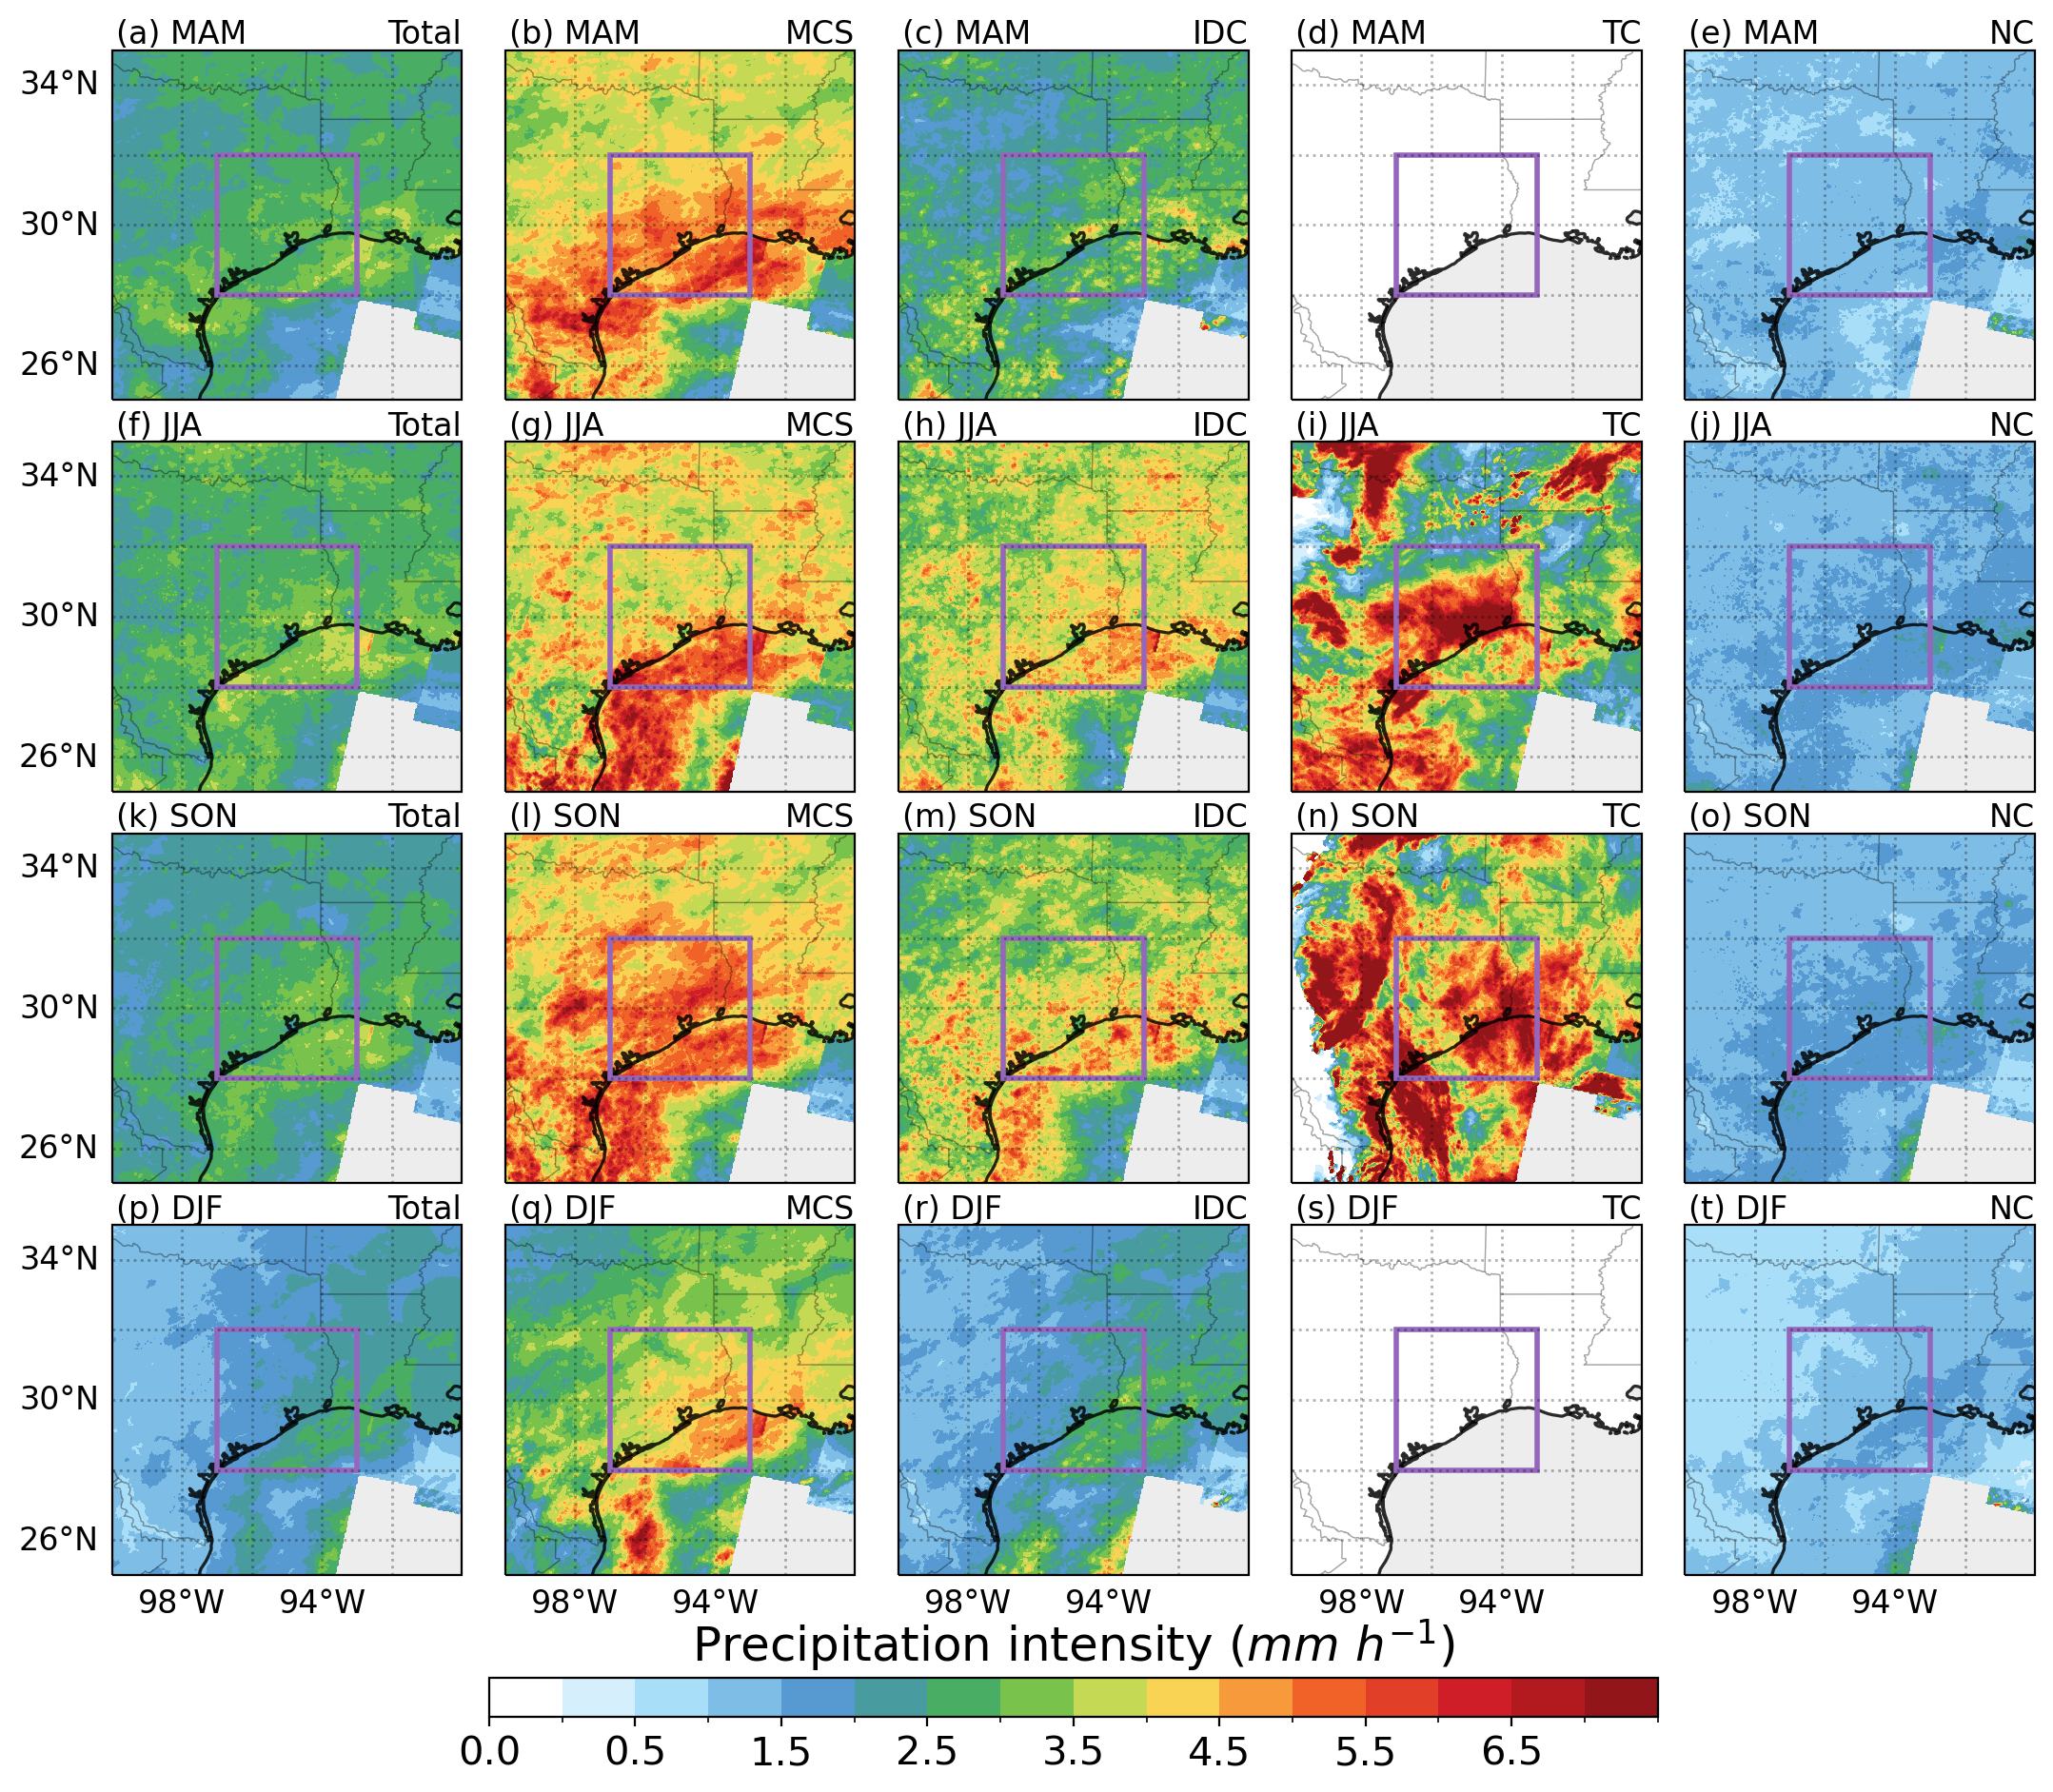

In [10]:
fig, axs = plt.subplots(
    4, 5, figsize=(11, 10), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.12, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnopqrst')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
clev = [0, 0.1]+list(np.arange(0.5,7.5,0.5))+[1000]
for i, season in enumerate(['MAM', 'JJA', 'SON', 'DJF']):
    _data = data[season]
    for j, v in enumerate(intensityvname): 
        ax = axs[cnt]
        cs, clev = plot_on_map(
            lon, lat, _data[v],
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            drawylabels=True if cnt in [0,5,10,15] else False,
            drawxlabels=True if cnt in [15,16,17,18,19] else False,
            title=season,
        )
        ax.text(0.01, 1.02, f'({abcd[cnt]}) {season}', transform=ax.transAxes, fontsize=12)
        ax.text(1, 1.02, f'{pcptype[j]}', transform=ax.transAxes, fontsize=12, ha='right')
        
        cnt += 1

ccs = plot_map.add_colorbar(
    cs, axs, clev[:-1:2],
    orientation='horizontal', 
    aspect=30, shrink=0.6,
    pad=0.06,
)

_ = ccs.ax.set_title('Precipitation intensity $(mm\ h^{-1})$')
fig.savefig('paper/Figure5.pdf', bbox_inches='tight')
fig.savefig('paper/Figure5.png', format='png', bbox_inches='tight', dpi=300)
